## Тестирование алгоритма генерации отпечатков и распознавания

In [74]:
import numpy as np
from array import array
from pydub import AudioSegment
from scipy.fft import rfft, rfftfreq
from scipy.signal import filtfilt, butter
from scipy.signal.windows import hamming
import matplotlib.pyplot as plt

In [75]:
# Парсим pydub AudioSegment в numpy массив уровней квантизации. Массив может состоять из 1 стобца(канала) при моно звуке и из 2 столбцов(каналов) при стерео
def pydub_to_np(audio: AudioSegment) -> np.ndarray:
    return np.array(audio.get_array_of_samples(), dtype=np.float32).reshape((-1, audio.channels))

# Трансформирует стерео звук в моно, вычисляя среднее между левым и правым каналом. dtype = int чтобы округлить до нижнего уровня
def stereo_to_mono(stereo: np.ndarray) -> np.ndarray:
    return np.mean(stereo, axis = 1, dtype=int)

def butter_lowpass(cutoff, frame_rate, order=3):
    nyq = 0.5 * frame_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def lowpass_filter(data, cutoff, frame_rate, order=5) -> np.ndarray:
    b, a = butter_lowpass(cutoff, frame_rate, order=order)
    return filtfilt(b, a, data).astype(np.short)

def downsampling(data, by: int = 4):
    return data[::by]

# Генератор, возвращает чанк из n элементов
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def get_windowed_fft_result(data, frame_rate: int, window_size: int, window_func = hamming) -> (list, list[list]):
    y_freq = []
    w = window_func(window_size)
    for chunk in chunks(data, window_size):
        if len(chunk) != window_size:
            break

        windowed_chunk = chunk * w
        fft_res = (2 / window_size) * np.abs(rfft(windowed_chunk))

        y_freq.append(fft_res)

    bins = rfftfreq(window_size, d = 1 / frame_rate)

    return bins, y_freq


In [76]:
#/home/araxal/harddrive/fma_small/149/149953.mp3
#/home/araxal/harddrive/fma_small/155/155066.mp3
sound = AudioSegment.from_mp3("/home/araxal/harddrive/fma_small/149/149953.mp3")

In [77]:
frame_rate = sound.frame_rate
sample_width = sound.sample_width ## квантизация (в байтах)
downsample_by = 4
downsampled_frame_rate = frame_rate / downsample_by
cutoff_frequency = downsampled_frame_rate / 2 ## nyquist

window_size = 1024

In [78]:
mono_sound = stereo_to_mono(pydub_to_np(sound))

In [79]:
max(mono_sound), min(mono_sound)

(32767, -32768)

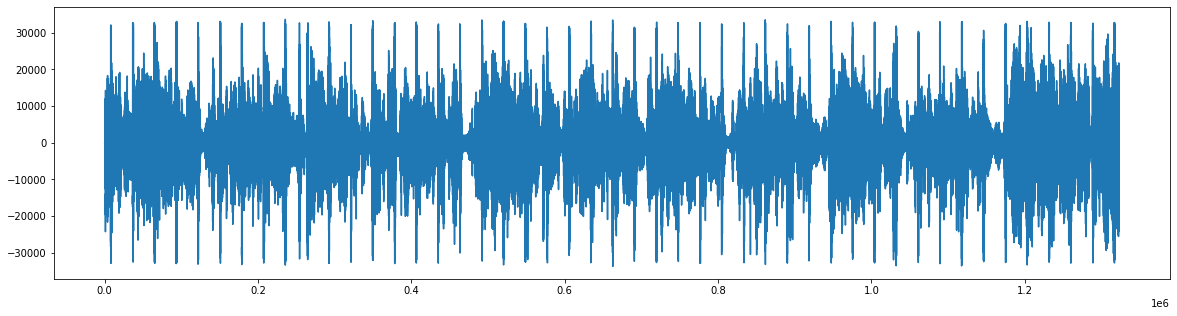

In [80]:
plt.plot(np.fft.irfft(np.fft.rfft(mono_sound)))

In [81]:
AudioSegment(array(sound.array_type, mono_sound), channels=1, sample_width=sample_width, frame_rate=44100)

In [82]:
filtered_sound = lowpass_filter(mono_sound, cutoff_frequency, frame_rate, order=5)

In [83]:
AudioSegment(array(sound.array_type, filtered_sound), channels=1, sample_width=sample_width, frame_rate=44100)

In [84]:
downsampled_sound = downsampling(filtered_sound, downsample_by)

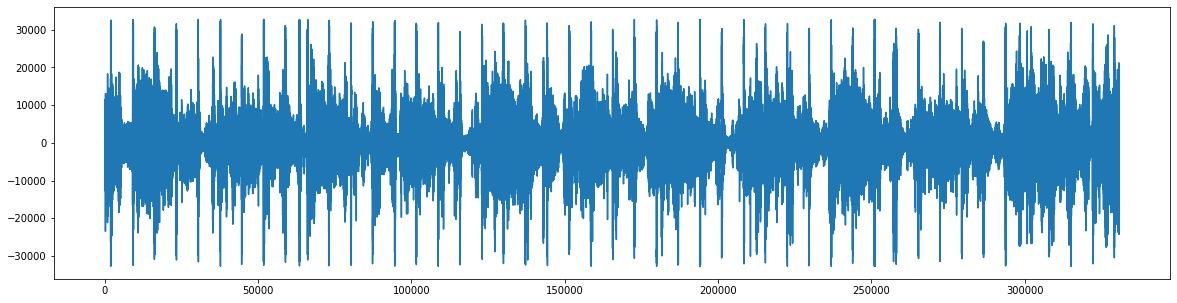

In [85]:
plt.plot(np.fft.irfft(np.fft.rfft(downsampled_sound)))

In [86]:
AudioSegment(array(sound.array_type, downsampled_sound), channels=1, sample_width=sample_width, frame_rate=downsampled_frame_rate)

Text(0, 0.5, 'Амплитуда')

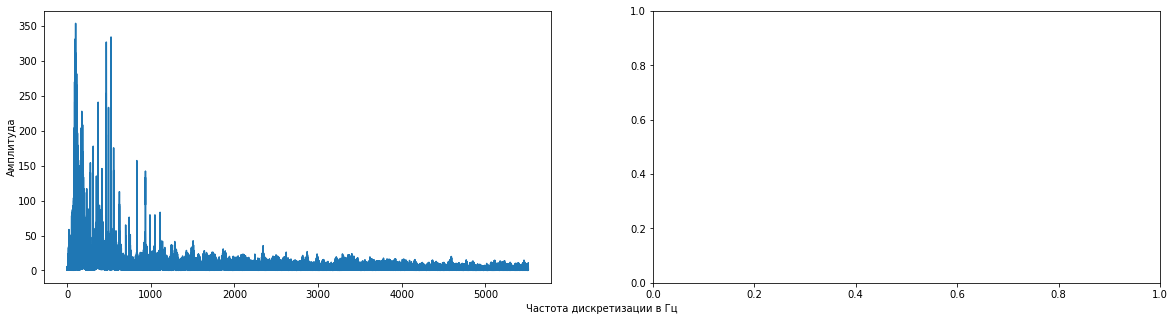

In [87]:
testChunk = hamming(len(downsampled_sound)) * downsampled_sound
testChunkFftY = np.abs(rfft(testChunk))
testChunk_x_freq = rfftfreq(len(testChunk), d = 1 / downsampled_frame_rate)
testChunk_y_freq = (2 / len(testChunk)) * np.abs(testChunkFftY)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(testChunk_x_freq, testChunk_y_freq)

fig.add_subplot(111, frameon= False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

plt.xlabel("Частота дискретизации в Гц")
plt.ylabel("Амплитуда")

In [88]:
bins, y_freq = get_windowed_fft_result(downsampled_sound, downsampled_frame_rate, window_size)

In [89]:
sound.duration_seconds

30.00269841269841

In [90]:
len(y_freq), len(y_freq[0])

(323, 513)

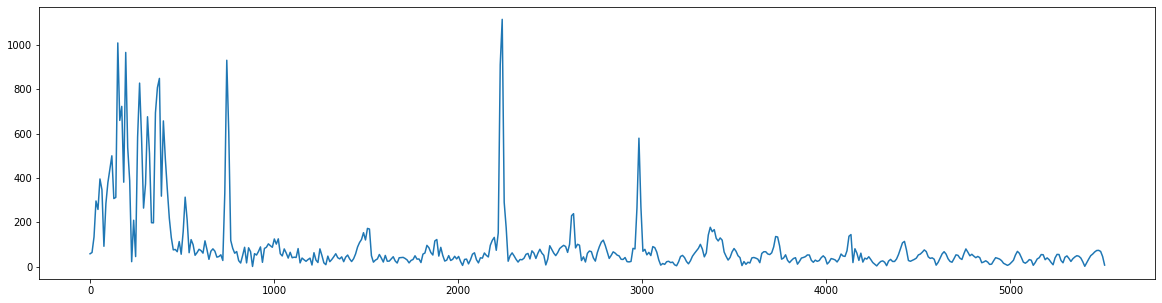

In [91]:
plt.plot(bins, y_freq[0])

In [92]:
# def compute_most_powerful_bin_indices(samples, bin_groups = ((0, 10),(10, 20),(20, 40),(40, 80),(80, 160),(160, 513))) -> list:
#     result = []
#     for sample in samples:
#         bins = []
#         for (min_bin, max_bin) in bin_groups:
#             interval = sample[min_bin:max_bin]
#             (m,i) = max((v,i) for i,v in enumerate(interval))
#
#             bins.append((m,i + min_bin))
#
#         bin_mean = np.mean([bin[0] for bin in bins])
#
#         bins = list(map(lambda el: el[1], filter(lambda el: el[0] >= bin_mean, bins)))
#         result.append(bins)
#
#     # Фильтруем бины, которые больше чем среднее максимальных бинов
#     # bin_mean = np.mean([item[0] for sublist in result for item in sublist])
#     #
#     # for idx, beans in enumerate(result):
#     #     result[idx] = list(map(lambda el: el[1], filter(lambda el: el[0] >= bin_mean, beans)))
#
#     return result


def compute_most_powerful_bin_indices(samples, bin_groups=(
        (0, 20), (20, 40), (40, 80), (80, 160), (160, 513)), coef = 1) -> list:
    result = []
    for sample in samples:
        bins = []
        for (min_bin, max_bin) in bin_groups:
            interval = sample[min_bin:max_bin]
            (m, i) = max((v, i) for i, v in enumerate(interval))

            bins.append((m, i + min_bin))

        result.append(bins)

    # Фильтруем бины, которые больше чем среднее максимальных бинов
    bin_mean = np.mean([item[0] for sublist in result for item in sublist])

    for idx, beans in enumerate(result):
        result[idx] = list(map(lambda el: el[1], filter(lambda el: el[0] >= bin_mean * coef, beans)))

    return result

In [93]:
compute_most_powerful_bin_indices(y_freq)

[[14, 69, 208],
 [33],
 [35, 71, 196],
 [70, 140, 207],
 [18, 36, 52],
 [],
 [],
 [34, 58],
 [34],
 [7, 58, 87, 232],
 [19, 20, 43, 87],
 [28, 58, 87],
 [16, 28, 58, 87],
 [16, 26, 46, 87],
 [44, 87],
 [26, 46, 87, 208],
 [17, 35, 46, 87],
 [32, 46, 87],
 [34, 46],
 [46, 87],
 [17, 46],
 [16, 30, 46],
 [11, 46],
 [],
 [15],
 [15, 30, 46],
 [15, 30],
 [352],
 [],
 [18, 36],
 [],
 [],
 [],
 [],
 [19, 39, 40, 80],
 [],
 [10],
 [18, 36],
 [44],
 [29, 43],
 [19, 20, 43],
 [29, 43, 114],
 [29, 44],
 [17, 20, 43],
 [35, 43],
 [43],
 [22, 43],
 [34, 43],
 [43],
 [43],
 [10, 20, 44],
 [62, 106],
 [15, 44],
 [52, 207],
 [],
 [],
 [17, 36, 44],
 [16, 36, 48, 86],
 [39, 156, 234],
 [39],
 [39],
 [43, 217],
 [39, 40],
 [],
 [10],
 [19, 20, 52, 98],
 [43, 98, 174],
 [49, 98],
 [49, 97],
 [39, 49, 98],
 [49],
 [16, 39, 40, 86, 173],
 [39, 49],
 [39, 49],
 [49],
 [49],
 [19, 39, 40],
 [],
 [9, 20],
 [34, 49],
 [],
 [],
 [35],
 [],
 [],
 [16],
 [18, 35, 70],
 [35, 46, 105],
 [35, 70, 106],
 [71],
 [],


In [94]:
%%time
most_powerful_bin_indices = compute_most_powerful_bin_indices(y_freq)

CPU times: user 24.1 ms, sys: 179 µs, total: 24.3 ms
Wall time: 23.9 ms


In [95]:
print(most_powerful_bin_indices, len(most_powerful_bin_indices), len (most_powerful_bin_indices[0]))

[[14, 69, 208], [33], [35, 71, 196], [70, 140, 207], [18, 36, 52], [], [], [34, 58], [34], [7, 58, 87, 232], [19, 20, 43, 87], [28, 58, 87], [16, 28, 58, 87], [16, 26, 46, 87], [44, 87], [26, 46, 87, 208], [17, 35, 46, 87], [32, 46, 87], [34, 46], [46, 87], [17, 46], [16, 30, 46], [11, 46], [], [15], [15, 30, 46], [15, 30], [352], [], [18, 36], [], [], [], [], [19, 39, 40, 80], [], [10], [18, 36], [44], [29, 43], [19, 20, 43], [29, 43, 114], [29, 44], [17, 20, 43], [35, 43], [43], [22, 43], [34, 43], [43], [43], [10, 20, 44], [62, 106], [15, 44], [52, 207], [], [], [17, 36, 44], [16, 36, 48, 86], [39, 156, 234], [39], [39], [43, 217], [39, 40], [], [10], [19, 20, 52, 98], [43, 98, 174], [49, 98], [49, 97], [39, 49, 98], [49], [16, 39, 40, 86, 173], [39, 49], [39, 49], [49], [49], [19, 39, 40], [], [9, 20], [34, 49], [], [], [35], [], [], [16], [18, 35, 70], [35, 46, 105], [35, 70, 106], [71], [], [19, 20, 40], [10, 37, 53], [], [32, 48], [16, 34, 49], [35, 70], [38, 49], [38, 49, 114],

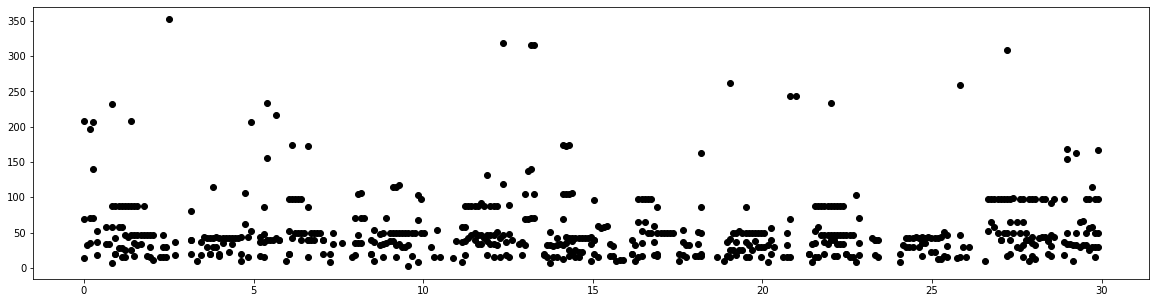

In [96]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
for idx, time in enumerate(most_powerful_bin_indices):
    for bin in time:
        plt.scatter(idx * window_size / downsampled_frame_rate, bin, c = 'k')

plt.show()

In [97]:
def get_flatten_bin_indices(data):
    transformed = []
    for time_idx, bins in enumerate(data):
        for bin in bins:
            transformed.append((time_idx, bin))
    return transformed

In [98]:
transformed = get_flatten_bin_indices(most_powerful_bin_indices)

In [99]:
transformed

[(0, 14),
 (0, 69),
 (0, 208),
 (1, 33),
 (2, 35),
 (2, 71),
 (2, 196),
 (3, 70),
 (3, 140),
 (3, 207),
 (4, 18),
 (4, 36),
 (4, 52),
 (7, 34),
 (7, 58),
 (8, 34),
 (9, 7),
 (9, 58),
 (9, 87),
 (9, 232),
 (10, 19),
 (10, 20),
 (10, 43),
 (10, 87),
 (11, 28),
 (11, 58),
 (11, 87),
 (12, 16),
 (12, 28),
 (12, 58),
 (12, 87),
 (13, 16),
 (13, 26),
 (13, 46),
 (13, 87),
 (14, 44),
 (14, 87),
 (15, 26),
 (15, 46),
 (15, 87),
 (15, 208),
 (16, 17),
 (16, 35),
 (16, 46),
 (16, 87),
 (17, 32),
 (17, 46),
 (17, 87),
 (18, 34),
 (18, 46),
 (19, 46),
 (19, 87),
 (20, 17),
 (20, 46),
 (21, 16),
 (21, 30),
 (21, 46),
 (22, 11),
 (22, 46),
 (24, 15),
 (25, 15),
 (25, 30),
 (25, 46),
 (26, 15),
 (26, 30),
 (27, 352),
 (29, 18),
 (29, 36),
 (34, 19),
 (34, 39),
 (34, 40),
 (34, 80),
 (36, 10),
 (37, 18),
 (37, 36),
 (38, 44),
 (39, 29),
 (39, 43),
 (40, 19),
 (40, 20),
 (40, 43),
 (41, 29),
 (41, 43),
 (41, 114),
 (42, 29),
 (42, 44),
 (43, 17),
 (43, 20),
 (43, 43),
 (44, 35),
 (44, 43),
 (45, 43),
 

In [100]:
def get_target_zones(data, target_zone_length = 5):
    groups = []
    for i in range(0, len(data) - target_zone_length + 1):
        groups.append(data[i: i + target_zone_length])
    return groups

def get_target_zones_with_anchors(data, target_zone_length = 5, anchor_shift = 3):
    target_zones = get_target_zones(data, target_zone_length = target_zone_length)
    result = []

    for i in range(0, len(data) - target_zone_length + 1 - anchor_shift):
        point = data[i]
        result.append((point, target_zones[i + 3]))
    return result

In [101]:
target_zones = get_target_zones_with_anchors(transformed)

In [102]:
target_zones

[((0, 14), [(1, 33), (2, 35), (2, 71), (2, 196), (3, 70)]),
 ((0, 69), [(2, 35), (2, 71), (2, 196), (3, 70), (3, 140)]),
 ((0, 208), [(2, 71), (2, 196), (3, 70), (3, 140), (3, 207)]),
 ((1, 33), [(2, 196), (3, 70), (3, 140), (3, 207), (4, 18)]),
 ((2, 35), [(3, 70), (3, 140), (3, 207), (4, 18), (4, 36)]),
 ((2, 71), [(3, 140), (3, 207), (4, 18), (4, 36), (4, 52)]),
 ((2, 196), [(3, 207), (4, 18), (4, 36), (4, 52), (7, 34)]),
 ((3, 70), [(4, 18), (4, 36), (4, 52), (7, 34), (7, 58)]),
 ((3, 140), [(4, 36), (4, 52), (7, 34), (7, 58), (8, 34)]),
 ((3, 207), [(4, 52), (7, 34), (7, 58), (8, 34), (9, 7)]),
 ((4, 18), [(7, 34), (7, 58), (8, 34), (9, 7), (9, 58)]),
 ((4, 36), [(7, 58), (8, 34), (9, 7), (9, 58), (9, 87)]),
 ((4, 52), [(8, 34), (9, 7), (9, 58), (9, 87), (9, 232)]),
 ((7, 34), [(9, 7), (9, 58), (9, 87), (9, 232), (10, 19)]),
 ((7, 58), [(9, 58), (9, 87), (9, 232), (10, 19), (10, 20)]),
 ((8, 34), [(9, 87), (9, 232), (10, 19), (10, 20), (10, 43)]),
 ((9, 7), [(9, 232), (10, 19), (1

In [103]:
from collections import defaultdict
def get_structure_to_unwind(target_zones) -> dict:
    result_dict = defaultdict(list)

    for zone in target_zones:
        anchor_time = zone[0][0]
        anchor_freq = zone[0][1]

        for point in zone[1]:
            result_dict[anchor_time].append((anchor_freq, point[1], point[0] - anchor_time))

    return result_dict

In [104]:
structure_to_unwind = get_structure_to_unwind(target_zones)

In [105]:
structure_to_unwind

defaultdict(list,
            {0: [(14, 33, 1),
              (14, 35, 2),
              (14, 71, 2),
              (14, 196, 2),
              (14, 70, 3),
              (69, 35, 2),
              (69, 71, 2),
              (69, 196, 2),
              (69, 70, 3),
              (69, 140, 3),
              (208, 71, 2),
              (208, 196, 2),
              (208, 70, 3),
              (208, 140, 3),
              (208, 207, 3)],
             1: [(33, 196, 1),
              (33, 70, 2),
              (33, 140, 2),
              (33, 207, 2),
              (33, 18, 3)],
             2: [(35, 70, 1),
              (35, 140, 1),
              (35, 207, 1),
              (35, 18, 2),
              (35, 36, 2),
              (71, 140, 1),
              (71, 207, 1),
              (71, 18, 2),
              (71, 36, 2),
              (71, 52, 2),
              (196, 207, 1),
              (196, 18, 2),
              (196, 36, 2),
              (196, 52, 2),
              (196, 34, 5)],
 

In [106]:
from collections import defaultdict
def get_hash_map(unwind_structure: dict):
    hash_map = defaultdict(list)

    for time, addresses in unwind_structure.items():
        for address in addresses:
            hash_map[address].append(time)
    return hash_map

In [107]:
hash_map = get_hash_map(structure_to_unwind)
hash_map[(14, 33, 1)]

[0]

# поиск

In [108]:
part_of_sound = downsampled_sound[50000:200000]

In [109]:
AudioSegment(array(sound.array_type, part_of_sound), channels=1, sample_width=sample_width, frame_rate=downsampled_frame_rate)

In [110]:
def perform_algo(sound, frame_rate, window_size):
    bins, y_freq = get_windowed_fft_result(sound, frame_rate, window_size)
    most_powerful_bin_indices = compute_most_powerful_bin_indices(y_freq)
    transformed = get_flatten_bin_indices(most_powerful_bin_indices)
    target_zones = get_target_zones_with_anchors(transformed)
    structure_to_unwind = get_structure_to_unwind(target_zones)
    return structure_to_unwind

In [111]:
part_of_algo = perform_algo(part_of_sound, downsampled_frame_rate, window_size)

In [112]:
part_of_algo

defaultdict(list,
            {0: [(43, 53, 2),
              (43, 117, 2),
              (43, 232, 2),
              (43, 15, 3),
              (43, 44, 3)],
             1: [(10, 117, 1),
              (10, 232, 1),
              (10, 15, 2),
              (10, 44, 2),
              (10, 52, 3),
              (44, 232, 1),
              (44, 15, 2),
              (44, 44, 2),
              (44, 52, 3),
              (44, 207, 3)],
             2: [(53, 15, 1),
              (53, 44, 1),
              (53, 52, 2),
              (53, 207, 2),
              (53, 207, 3),
              (117, 44, 1),
              (117, 52, 2),
              (117, 207, 2),
              (117, 207, 3),
              (117, 17, 5),
              (232, 52, 2),
              (232, 207, 2),
              (232, 207, 3),
              (232, 17, 5),
              (232, 37, 5)],
             3: [(15, 207, 1),
              (15, 207, 2),
              (15, 17, 4),
              (15, 37, 4),
              (15, 44, 4)

In [113]:
hm = defaultdict(int)

for (x, y) in part_of_algo.items():
    for point in y:
        if point in hash_map:
            for z in hash_map[point]:
                hm[z] += 1

In [114]:
len(part_of_algo), len(structure_to_unwind), len(hm)

(126, 263, 226)

In [115]:
filtered_hm = {  k: hm[k] for k in hm.keys() if hm[k] >= 4 }

In [116]:
filtered_hm

{47: 4,
 158: 7,
 261: 4,
 263: 4,
 265: 6,
 269: 11,
 50: 10,
 161: 7,
 52: 6,
 53: 5,
 56: 11,
 235: 37,
 57: 11,
 58: 19,
 71: 23,
 237: 26,
 299: 13,
 60: 9,
 69: 23,
 72: 44,
 59: 6,
 73: 15,
 61: 4,
 46: 7,
 62: 12,
 64: 5,
 175: 5,
 300: 4,
 65: 21,
 294: 12,
 40: 5,
 155: 12,
 43: 6,
 182: 46,
 174: 9,
 177: 20,
 287: 7,
 66: 16,
 67: 46,
 178: 10,
 180: 24,
 288: 10,
 290: 30,
 291: 17,
 297: 30,
 319: 7,
 176: 11,
 289: 8,
 298: 11,
 302: 4,
 122: 14,
 159: 5,
 106: 6,
 292: 12,
 70: 23,
 74: 13,
 216: 10,
 68: 26,
 95: 44,
 97: 27,
 98: 25,
 99: 30,
 100: 28,
 101: 33,
 102: 37,
 103: 27,
 105: 29,
 207: 31,
 209: 22,
 210: 21,
 211: 44,
 212: 31,
 213: 40,
 214: 26,
 293: 22,
 295: 16,
 206: 18,
 179: 13,
 318: 5,
 75: 13,
 215: 7,
 76: 5,
 104: 21,
 183: 22,
 184: 17,
 312: 20,
 315: 18,
 185: 8,
 186: 8,
 44: 4,
 86: 5,
 87: 6,
 88: 4,
 16: 39,
 167: 7,
 91: 6,
 92: 12,
 126: 16,
 96: 9,
 107: 5,
 301: 6,
 296: 4,
 187: 4,
 10: 16,
 242: 10,
 121: 21,
 128: 22,
 11: 12,
 

In [117]:
len(filtered_hm) # а если 1024 то 320

155

In [118]:
song_counts = defaultdict(int)
song_id = 111
for time in filtered_hm.keys():
    song_counts[song_id] += 1

In [119]:
song_counts

defaultdict(int, {111: 155})

In [120]:
coef = 0.9
filter_threshold = coef * len(part_of_algo)

filtered_song_counts = {  k: song_counts[k] for k in song_counts.keys() if song_counts[k] >= filter_threshold }
filtered_song_counts

{111: 155}

In [121]:
part_of_algo

defaultdict(list,
            {0: [(43, 53, 2),
              (43, 117, 2),
              (43, 232, 2),
              (43, 15, 3),
              (43, 44, 3)],
             1: [(10, 117, 1),
              (10, 232, 1),
              (10, 15, 2),
              (10, 44, 2),
              (10, 52, 3),
              (44, 232, 1),
              (44, 15, 2),
              (44, 44, 2),
              (44, 52, 3),
              (44, 207, 3)],
             2: [(53, 15, 1),
              (53, 44, 1),
              (53, 52, 2),
              (53, 207, 2),
              (53, 207, 3),
              (117, 44, 1),
              (117, 52, 2),
              (117, 207, 2),
              (117, 207, 3),
              (117, 17, 5),
              (232, 52, 2),
              (232, 207, 2),
              (232, 207, 3),
              (232, 17, 5),
              (232, 37, 5)],
             3: [(15, 207, 1),
              (15, 207, 2),
              (15, 17, 4),
              (15, 37, 4),
              (15, 44, 4)

In [122]:
deltas = defaultdict(int)

for (time, points) in part_of_algo.items():
    for point in points:
        song_times = hash_map[point]
        for song_time in song_times:
            deltas[time - song_time] += 1

# dict(sorted(deltas.items(), key = lambda item: item[1], reverse=True))
max(deltas.values())

532

In [123]:
dict(sorted(deltas.items(), key = lambda item: item[1], reverse=True))

{-49: 532,
 -160: 108,
 -161: 57,
 -48: 56,
 -159: 55,
 -50: 54,
 -47: 53,
 -163: 51,
 -158: 49,
 -162: 45,
 -51: 44,
 62: 35,
 -157: 34,
 -155: 33,
 -46: 32,
 -165: 31,
 -156: 29,
 61: 29,
 63: 28,
 64: 27,
 -45: 26,
 -52: 25,
 65: 25,
 -154: 24,
 -164: 23,
 -53: 23,
 -44: 23,
 66: 23,
 -54: 21,
 -166: 19,
 60: 19,
 -21: 18,
 59: 17,
 -271: 15,
 -42: 15,
 -77: 14,
 -167: 14,
 -43: 14,
 -152: 14,
 68: 14,
 -79: 13,
 -55: 13,
 -153: 13,
 -35: 12,
 -80: 12,
 -191: 12,
 67: 12,
 -269: 11,
 -274: 11,
 -78: 11,
 -151: 11,
 -278: 10,
 -272: 10,
 -41: 10,
 -57: 10,
 58: 10,
 69: 10,
 -273: 9,
 -56: 9,
 -76: 9,
 -132: 9,
 -14: 9,
 57: 9,
 70: 9,
 -126: 8,
 -189: 8,
 -193: 8,
 -188: 8,
 -267: 8,
 -130: 8,
 -169: 8,
 -39: 7,
 -168: 7,
 -128: 7,
 -127: 7,
 29: 7,
 31: 7,
 -81: 6,
 -82: 6,
 -194: 6,
 -187: 6,
 -190: 6,
 -276: 6,
 -40: 6,
 -72: 6,
 -174: 6,
 -20: 6,
 -19: 6,
 -131: 6,
 -17: 6,
 -16: 6,
 -129: 6,
 32: 6,
 56: 6,
 -265: 5,
 -279: 5,
 -83: 5,
 -277: 5,
 -270: 5,
 -186: 5,
 -74: 5,
 -7